# **Diversion Data Exploratory Analysis**

Author: Bridget Bittmann

Date Created: 09/14/2021

Date Modified: 01/14/2022

In [1]:
#Import necessary packages

import pandas as pd #to work with data arrays
import numpy as np #to work with arrays and statistics
import matplotlib.pyplot as plt #create graphs 
from matplotlib.dates import DateFormatter #to help with timeseries
import glob #to batch import csv files
from sklearn import metrics #to find r2 values from regression
!pip install pymannkendall
import pymannkendall as mk #used to perform mann-kendall stationarity test
from sklearn.cluster import KMeans #to cluster using kmeans
import os #for file output paths
import matplotlib.patches as mpatches
import matplotlib.lines as Line2D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Navigate to your directory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Navigate to workspace

%cd /content/drive/MyDrive/spatial_colab/
%ls

/content/drive/MyDrive/spatial_colab
datasets/  pod_pou_lulcc/


In [ ]:
#Import data files
#Can comment after first run 

# div_wd63 = pd.read_csv('datasets/diversion_timeseries/WD63.csv', parse_dates=['DiversionDate'], index_col=['DiversionDate'])
# full_wd63 = pd.read_csv('datasets/diversion_timeseries/WD63_WRA_all.csv', parse_dates=['DataDate'], index_col=['DataDate'])
# print(div_wd63.dtypes)
# print(full_wd63.dtypes)

In [ ]:
## RENAME THE COLUMNS TO MATCH OLD TIMESERIES DESCRIPTIONS
## Can comment out after first run

# full_wd63 = full_wd63.rename(columns={'SiteID':'HydrologyID', 'FullName':'DiversionName',
#                                       'Description':'DiversionTypeDescription', 'DataDate':'DiversionDate'})

# ## replace SURPRISE VALLEY/MICRON with surprise_vy_micron to export CSV

# full_wd63['DiversionName'] = full_wd63['DiversionName'].replace(to_replace='SURPRISE VALLEY/MICRON',
#                                                                 value='SURPRISE_VALLEY_MICRON')

In [ ]:
### CREATE A CSV FILE FOR EACH DIVERSION ###

#This section is useful to clean, sort, and individually export each csv
#Can comment section out after first run 

# div_name = np.unique(full_wd63['DiversionName']) #get unique identifier for each div point
# print(div_name)

# for n in div_name:
#   canal = full_wd63[full_wd63['DiversionName']== n] #creates a dataframe for each canal name
#   canal = canal.sort_index() #sorts data by date
#   file_name = 'datasets/diversion_timeseries/fulltime_individual_canals/'+ str(n) +'.csv' #creates a file path
#   canal.to_csv(file_name) #exports csv to directory

In [4]:
### IMPORT ALL NEW CSV FILES INTO ONE DATAFRAME ###

all_files = [] #creates a list space for all the dataframes

csv = glob.glob('datasets/diversion_timeseries/fulltime_individual_canals/*.csv') #name for all the csv files
for f in csv: 
  df = pd.read_csv(f, parse_dates=['DataDate'], index_col=['DataDate'])
  all_files.append(df) #appends dataframes to one file list

extras = ['ANDREWS.csv', 'BAXTER.csv','BID No 1.csv', 
          'BOWMAN AND SWISHER.csv', 
          'Clayton Lateral.csv', 'CRAWFORTH.csv', 'HAAS.csv',
          'ISLAND HIGHLINE.csv', 'LOWER CENTER POINT.csv',
          'MAMMON.csv', 'MCCONNEL ISLAND.csv', 'McCurry Pump.csv', 
          'PARMA.csv', 'OBENDORF.csv', 'STUTHEIT.csv']

years = np.arange(1987,2021)

for i in range(len(extras)):
  file_name = os.path.join('datasets/diversion_timeseries/individual_canals/'+extras[i])
  all_files.append(pd.read_csv(file_name, parse_dates=['DiversionDate'], index_col='DiversionDate'))

In [5]:
## DATA QUALITY CONTROL PRIOR TO ANALYSIS ##

## Select only the diversions known to serve irrigation districts
#  Will remove reservoir, natural flow, and return flow data

diversion_list = [] #create a list to store the diversion data frame in

for i in range(len(all_files)):
  sel_data = all_files[i]
  data_type = sel_data['DiversionTypeDescription'][1]
  if data_type == 'Reservoir' or data_type=='Flow' or data_type=='Drain' :
    None
  else:
    diversion_list.append(sel_data)

## Select diversions with data from 1987-2021 for study
## Crop older years off and keep shorter ones

fullextent_list = []

for i in range(len(diversion_list)):
  sel_data = diversion_list[i]
  oldest_year = sel_data.index.year[0]
  if oldest_year <= 1987:
    sel_data = sel_data.truncate(before='1987-01-01')
    fullextent_list.append(sel_data)
  else:
    fullextent_list.append(sel_data)

## Find the names of all the canals in the dataframe list

full_df = pd.concat(fullextent_list)
names = full_df['DiversionName'].unique()

## Fill in any missing winter values with 0 starting at 1987-01-01

dt_series = pd.date_range(start='1987-01-01', end='1987-01-31', freq = 'D' )
dt_df = pd.DataFrame(dt_series, index=dt_series)

canalss = []

for i in range(len(fullextent_list)):
  canal = fullextent_list[i] #selects the specific diversion dataframe
  if canal.empty:
    None
  else:
    div_name = canal['DiversionName'][0]
    canal = pd.concat([dt_df, canal]) #adds the pandas series of dates to dataframe
    canal = canal.drop(labels=0, axis=1) #dropes the series column
    canal = canal.loc[~canal.index.duplicated(),:] #removes any duplicate index values
    canal = canal.asfreq('d') #fill each daily value
    canal['CFS'] = canal['CFS'].fillna(value=0) #fills CFS Nan values with 0, assumed during winter months or no data
    canal['CFS'] = canal['CFS'].abs()
    canal['DiversionName'] = canal['DiversionName'].fillna(div_name) #fills Nan diversion name values
    canalss.append(canal)

## Remove pioneer dixie from original analysis until figuring out how to manage it

canals_nopd = []

for i in range(len(canalss)):
  canal = canalss[i]
  if canal['DiversionName'].iloc[0] != 'PIONEER DIXIE':
    canals_nopd.append(canal)
  else: 
    None

## Remove diversions from upper boise river basin

canals_lbrb = []

for i in range(len(canals_nopd)):
  canal = canals_nopd[i]
  name = canal['DiversionName'][0]
  if name == 'USFS LUCKY PEAK NURSERY' or name == 'IPCO Instream' or name == 'OTTER' or  name == 'OSPREY' or name == 'DISCOVERY PARK' or name == 'BUREAU OF RECLAMATION INSTREAM FLOW RELEASE' or name == 'FISH AND GAME INSTREAM FLOW RELEASE' or name == 'HERRICK' or name == 'GREEN RANCH' or name == 'Ranch HOA' or name == 'SANDY POINT' or name =='SPRING SHORES' or name == 'WILDERNESS RANCH' or name == 'WILLIAMS PARK' or name == 'zz--Unidentified Site--' or name == 'WOODS':
    None
  else: 
    canals_lbrb.append(canal)

# Convert cfs to acre-ft per day

canals = []

for i in range(len(canals_lbrb)):
  canal = canals_lbrb[i]
  canal['Acre_feet'] = canal['CFS']*86400/43559.9
  canals.append(canal)


In [6]:
## ----------------------------- ##
## MERGE ALL DATAFRAMES INTO ONE ## 
## ----------------------------- ##

full_df = pd.concat(canals).drop(columns =['MeasurementTypeDescription', 
                                           'HydrologyID', 
                                           'WaterDistrictNumber',
                                           'Agency',
                                           'DiversionTypeDescription'], axis=1)

names = full_df['DiversionName'].unique()

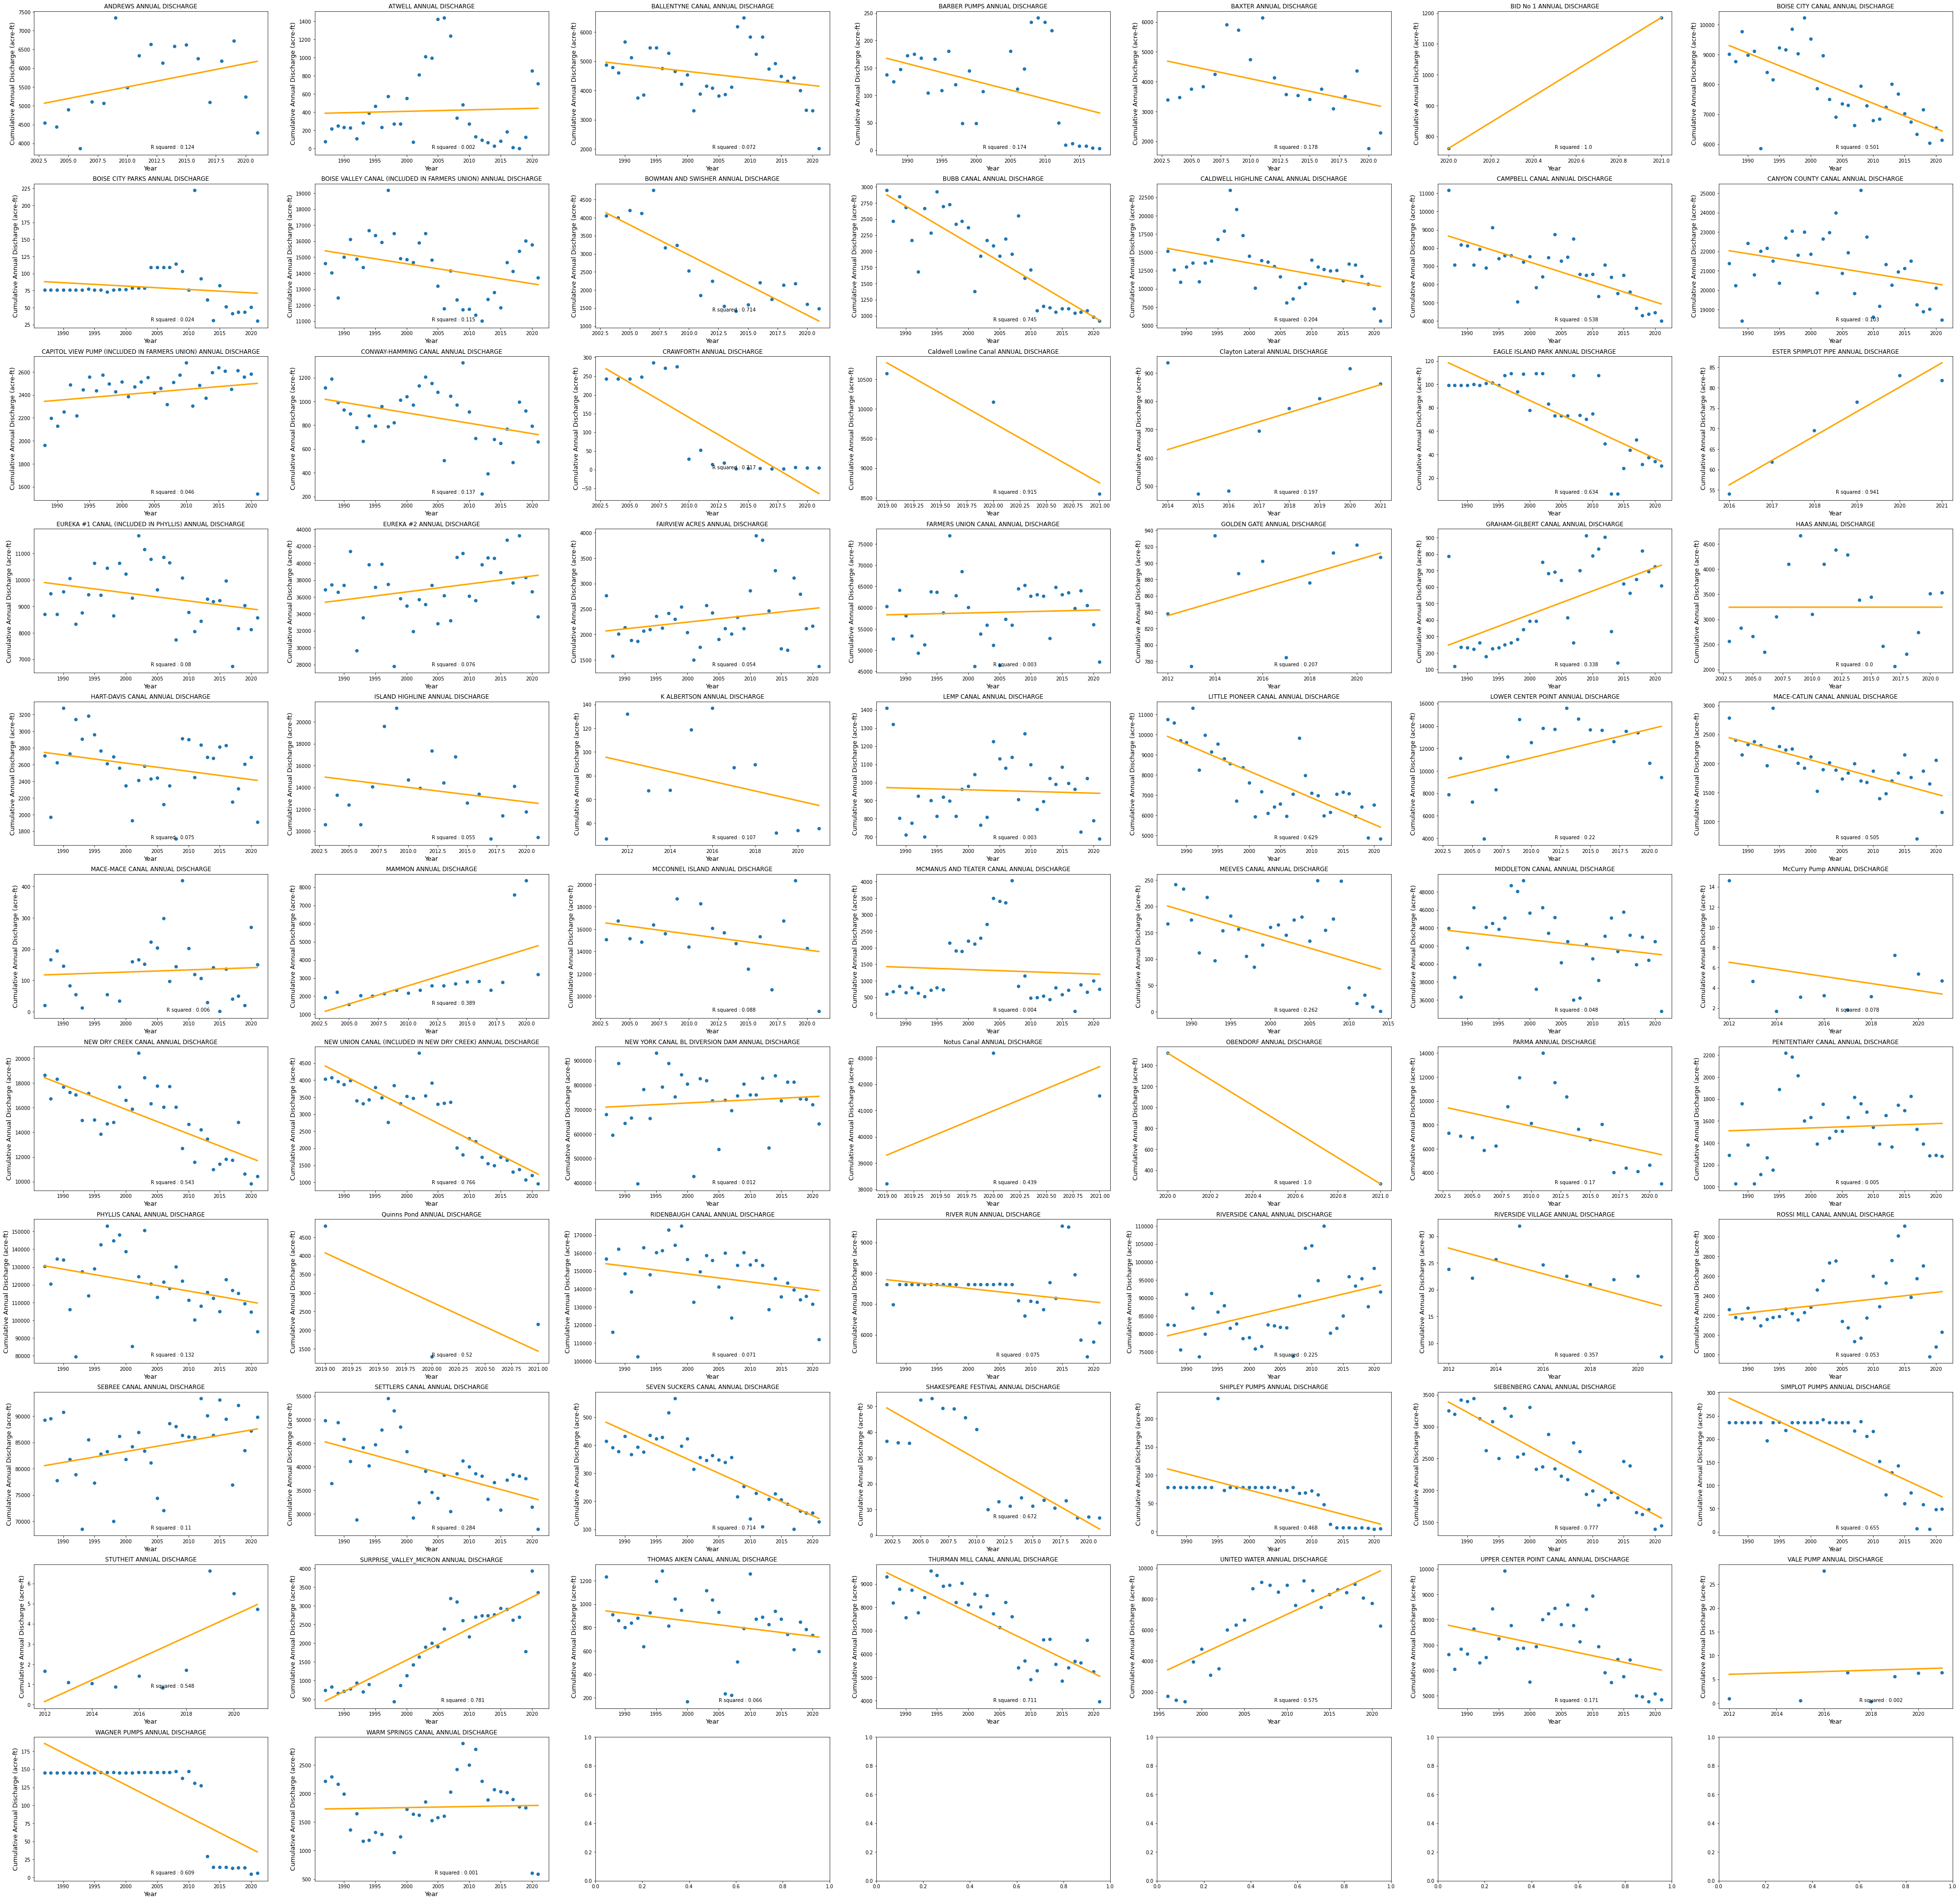

In [7]:
### FIND THE TOTAL WATER DIVERTED ANNUALLY ###

tot = full_df.groupby([full_df.index.year,'DiversionName']).sum(['Acre_feet'])   \
      .sort_values('DiversionName').reset_index().rename(columns={'level_0':'Year'}).sort_values(['DiversionName','Year'])  \
      .reset_index() #use group by to sum the daily values and drop extra columns
tot = tot.replace(0, np.nan).dropna().reset_index().drop(columns=['level_0','index'],axis=1) #clip each drain to the correct extent
names = tot['DiversionName'].unique()

## CALCULATE A REGRESSION FOR EACH DRAIN ## 

regress = []
rsquared = np.empty(len(names))

for i in range(len(names)):
  df = pd.DataFrame(tot[tot['DiversionName']==names[i]])
  mod = np.polyfit(df['Year'].values, df['Acre_feet'].values, deg=1) #calculates model coefficients
  df['Model'] = np.polyval(mod, df['Year'].values) #calculate model output values
  rsquared[i] = metrics.r2_score(df['Acre_feet'].values, df['Model'].values) #calculate rsquared for model
  regress.append(df)

regression= pd.concat(regress) #put list of dataframes into one

## CREATE SUBPLOTS FOR THE CHART ##

i,j = 0,0
plot_row = 7 #number of plots per row in figure
figure, ax = plt.subplots(11, plot_row, figsize=(70,70)) #create the figure

for n in range(len(names)): #run a for loop to add all plots to figure
  canal = regression[regression['DiversionName']==names[n]]
  ax[i][j].plot(canal['Year'], canal['Acre_feet'], 'o')
  ax[i][j].plot(canal['Year'], canal['Model'], color = 'orange', linewidth=3)
  ax[i][j].set_ylabel('Cumulative Annual Discharge (acre-ft)', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(names[n]+' ANNUAL DISCHARGE')
  text = 'R squared : '+str(np.around(rsquared[n], 3))
  ax[i][j].text(np.median(canal['Year']), np.min(canal['Acre_feet']), s=text)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/totals.png')

In [8]:
## CALCULATE BASIC VOLUME STATISTICS ##

stats = []

for i in range(len(canals)):
  canal = canals[i]
  totals = tot[tot['DiversionName'] == canal['DiversionName'][0]]
  avg_annual = np.mean(totals['Acre_feet'])
  std_annual = np.std(totals['Acre_feet'])
  avg_vol = np.mean(canal['Acre_feet'][canal['Acre_feet'] != 0])
  std_dev_vol = np.std(canal['Acre_feet'][canal['Acre_feet'] != 0])
  maximum = np.max(totals['Acre_feet'])
  minimum = np.min(totals['Acre_feet'])
  stats.append([canal['DiversionName'][0], avg_annual, std_annual, maximum, minimum, avg_vol,
                std_dev_vol])

base_stats = pd.DataFrame(stats, columns = ['DiversionName', 'Annual Avg (acre-ft/yr)', 'Annual Std (acre-ft/yr)',
                                            'Maximum', 'Minimum',
                                            'Mean Volume (acre-ft per day)', 
                                            'Std_dev Volume (acre-ft per day)' 
                                            ]).sort_values(by=['DiversionName']).reset_index().drop(columns='index',axis=1)

base_stats.to_csv('datasets/diversion_timeseries/figures/stats.csv')

In [9]:
## FIND OTHER IRRIGATION SEASON TIMING METRICS ##

## Create a dataframe housing info:                 ##
## ------------------------------------------------ ##
## Column 1: Name of diversion                      ##
## Column 2: Date start of Irrigation season        ##
## Column 3: Day of year start of Irrigation season ##
## Column 4: Date end of irrigation season          ##
## Column 5: Date of year end of Irrigation season  ##
## Column 6: Length of Irrigation Season            ##
## ------------------------------------------------ ##

season_df = []

## Add a column to original canals dataframe to get the daily cumulative sum of 
#  discharge each year during the irrigation season (used for start and end days)
for i in range(len(canals)):
  for j in range(len(years)):
    sub_canal = canals[i]
    canals[i]['Sum'] = sub_canal.groupby(sub_canal.index.year)['CFS'].cumsum()

for i in range(len(canals)):
  length = []
  for y in range(len(years)):
    canal_data = canals[i]
    canal_name = canal_data['DiversionName'][1]
    canal_by_year = canal_data[canal_data.index.year == years[y]]
    if np.max(canal_by_year['Sum']) != 0:
      min_Ix = np.where(canal_by_year['Sum'] == np.min(canal_by_year['Sum']))
      min_Ix = min_Ix[0]
      min_Ix = min_Ix[-1]
      start_date = canal_by_year.index[min_Ix]
      start_dayofyear = canal_by_year.index.dayofyear[min_Ix]
    else:
      start_date = 'NaN'
      start_dayofyear = 'NaN'
    if np.max(canal_by_year['Sum'] != 0):
      max_Ix = np.where(canal_by_year['Sum'] == np.max(canal_by_year['Sum']))
      max_Ix= max_Ix[0]
      max_Ix = max_Ix[0]
      end_date = canal_by_year.index[max_Ix]
      end_dayofyear = canal_by_year.index.dayofyear[max_Ix]
    else: 
      end_date = 'NaN'
      end_dayofyear ='NaN'
    if end_date != 'NaN':
      irrig_season_range = end_dayofyear-start_dayofyear
    else: 
      irrig_season_range == 'NaN'
    length.append([canal_name, years[y], start_date, start_dayofyear, end_date, end_dayofyear, irrig_season_range])
  length_df = pd.DataFrame(length, columns = ['DiversionName','Year', 'StartDate', 'StartDayofYear',
                                            'EndDate', 'EndDayofYear', 'Range']).dropna()
  length_df = length_df.reset_index().drop('index', axis=1)
  season_df.append(length_df)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the

In [35]:
## ------------------------------------------------------------------- ##
## GET EARLIEST AND LATEST DATES FOR START AND END OF SEASON EACH YEAR ## 
## ------------------------------------------------------------------- ##

timing = pd.concat(season_df)
timing['MonthStart'] = pd.DatetimeIndex(timing['StartDate']).month
timing['MonthEnd'] = pd.DatetimeIndex(timing['EndDate']).month
## Analyze where the irrigation starts and ends at anamolous times
jan = timing[timing['MonthStart'] == 1]
# print(jan['DiversionName'].unique())
feb = timing[timing['MonthStart'] == 2]
# print(feb['DiversionName'].unique())
dec = timing[timing['MonthEnd'] == 12]
# print(dec['DiversionName'].unique())

## Remove diversions with anamolous start and end dates
min_test = timing[timing['DiversionName'] != 'NEW YORK CANAL BL DIVERSION DAM']
min_test = min_test[min_test['DiversionName'] != 'SURPRISE_VALLEY_MICRON']
min_test = min_test[min_test['DiversionName'] != 'UNITED WATER']
min_test = min_test[(min_test['DiversionName'] != 'RIVER RUN') | (min_test['Year'] != 2016)]
min_test = min_test[(min_test['DiversionName'] != 'RIVER RUN') | (min_test['Year'] != 2017)]
min_test = min_test[(min_test['DiversionName'] != 'RIVER RUN') | (min_test['Year'] != 2018)]
min_test = min_test[(min_test['DiversionName'] != 'SEVEN SUCKERS CANAL') | (min_test['Year'] != 1998)]
min_test = min_test[(min_test['DiversionName'] != 'SEVEN SUCKERS CANAL') | (min_test['Year'] != 1997)]
min_vals = pd.DataFrame(min_test.groupby('Year').StartDate.agg('min'))
max_vals = pd.DataFrame(min_test.groupby('Year').EndDate.agg('max'))

## Get the earliest start and latest end date of the irrigation season 
min_max = min_vals.merge(max_vals, on='Year', how='left')
min_max = min_max.rename({'min':'Start Date',
                          'mean_x':'Mean Start',
                          'max': 'End Date',
                          'mean_y':'Mean End'}, axis=1)

min_max.to_csv('datasets/climate_stats/start_end_dates.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})


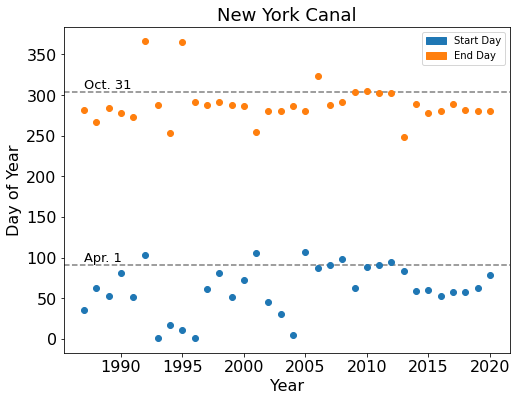

In [ ]:
plt.figure(figsize = (8,6))
plt.axhline(y=91, color='grey', linestyle = '--')
plt.text(1987, 95, 'Apr. 1', fontsize=13)
plt.axhline(y=304, color='grey', linestyle = '--')
plt.text(1987, 308, 'Oct. 31', fontsize=13)
plt.plot(timing['Year'][timing['DiversionName']== 'NEW YORK CANAL BL DIVERSION DAM'], 
         timing['StartDayofYear'][timing['DiversionName']=='NEW YORK CANAL BL DIVERSION DAM'], 'o')
plt.plot(timing['Year'][timing['DiversionName']== 'NEW YORK CANAL BL DIVERSION DAM'], 
         timing['EndDayofYear'][timing['DiversionName']=='NEW YORK CANAL BL DIVERSION DAM'], 'o')
start = mpatches.Patch(color='tab:blue', label='Start Day')
end = mpatches.Patch(color = 'tab:orange', label='End Day')
plt.xlabel('Year', size=16)
plt.ylabel('Day of Year', size=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('New York Canal', size=18)
plt.legend(handles=[start,end])
plt.savefig('datasets/diversion_timeseries/figures/ny_start_end.png')
plt.show()

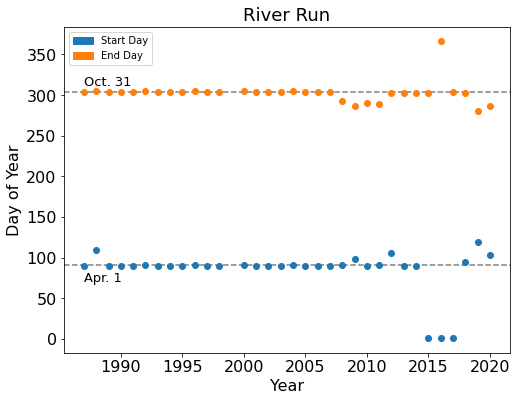

In [ ]:
plt.figure(figsize = (8,6))
plt.axhline(y=91, color='grey', linestyle = '--')
plt.text(1987, 70, 'Apr. 1', fontsize=13)
plt.axhline(y=304, color='grey', linestyle = '--')
plt.text(1987, 312, 'Oct. 31', fontsize=13)
plt.plot(timing['Year'][timing['DiversionName']== 'RIVER RUN'], 
         timing['StartDayofYear'][timing['DiversionName']=='RIVER RUN'], 'o')
plt.plot(timing['Year'][timing['DiversionName']== 'RIVER RUN'], 
         timing['EndDayofYear'][timing['DiversionName']=='RIVER RUN'], 'o')
start = mpatches.Patch(color='tab:blue', label='Start Day')
end = mpatches.Patch(color = 'tab:orange', label='End Day')
plt.xlabel('Year', size=16)
plt.ylabel('Day of Year', size=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('River Run', size=18)
plt.legend(handles=[start,end])
plt.savefig('datasets/diversion_timeseries/figures/riverrun_start_end.png')
plt.show()

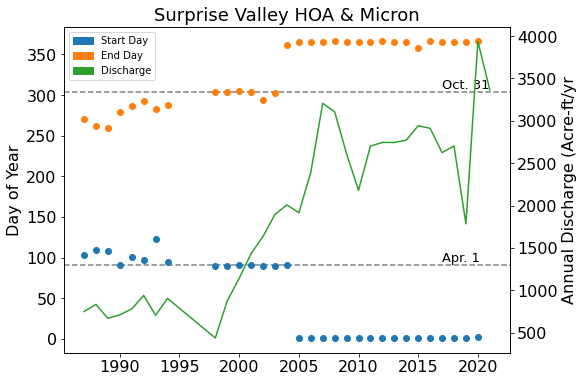

In [11]:
plt.figure(figsize = (8,6))
plt.axhline(y=91, color='grey', linestyle = '--')
plt.text(2017, 95, 'Apr. 1', fontsize=13)
plt.axhline(y=304, color='grey', linestyle = '--')
plt.text(2017, 308, 'Oct. 31', fontsize=13)
plt.plot(timing['Year'][timing['DiversionName']== 'SURPRISE_VALLEY_MICRON'], 
         timing['StartDayofYear'][timing['DiversionName']=='SURPRISE_VALLEY_MICRON'], 'o')
plt.plot(timing['Year'][timing['DiversionName']== 'SURPRISE_VALLEY_MICRON'], 
         timing['EndDayofYear'][timing['DiversionName']=='SURPRISE_VALLEY_MICRON'], 'o')
plt.ylabel('Day of Year', size=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.twinx()
plt.plot(tot['Year'][tot['DiversionName']== 'SURPRISE_VALLEY_MICRON'], 
         tot['Acre_feet'][tot['DiversionName']=='SURPRISE_VALLEY_MICRON'], '-', color='tab:green')
start = mpatches.Patch(color='tab:blue', label='Start Day')
end = mpatches.Patch(color = 'tab:orange', label='End Day')
tri = mpatches.Patch(color = 'tab:green', label='Discharge')
plt.xlabel('Year', size=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Annual Discharge (Acre-ft/yr', size=16)
plt.title('Surprise Valley HOA & Micron', size=18)
plt.legend(handles=[start,end, tri])
plt.savefig('datasets/diversion_timeseries/figures/micron_start_end.png')
plt.show()

In [ ]:
display(tot)

,Year,DiversionName,CFS,Acre_feet
0,2003,ANDREWS,2293.00,4548.109615
1,2004,ANDREWS,2240.20,4443.382101
2,2005,ANDREWS,2468.50,4896.209587
3,2006,ANDREWS,1949.50,3866.785736
4,2007,ANDREWS,2576.50,5110.424955
...,...,...,...,...
1936,2017,WARM SPRINGS CANAL,956.76,1897.710142
1937,2018,WARM SPRINGS CANAL,890.10,1765.491656
1938,2019,WARM SPRINGS CANAL,884.11,1753.610637
1939,2020,WARM SPRINGS CANAL,307.75,610.414624


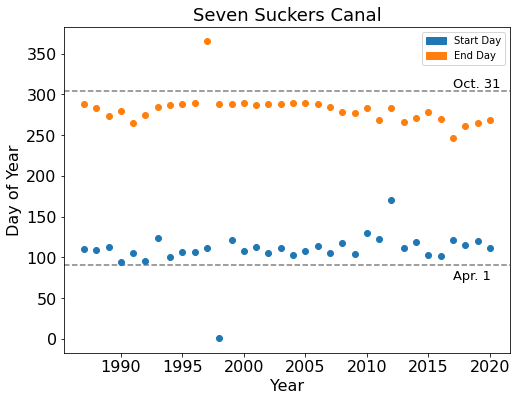

In [ ]:
plt.figure(figsize = (8,6))
plt.axhline(y=91, color='grey', linestyle = '--')
plt.text(2017, 73, 'Apr. 1', fontsize=13)
plt.axhline(y=304, color='grey', linestyle = '--')
plt.text(2017, 308, 'Oct. 31', fontsize=13)
plt.plot(timing['Year'][timing['DiversionName']== 'SEVEN SUCKERS CANAL'], 
         timing['StartDayofYear'][timing['DiversionName']=='SEVEN SUCKERS CANAL'], 'o')
plt.plot(timing['Year'][timing['DiversionName']== 'SEVEN SUCKERS CANAL'], 
         timing['EndDayofYear'][timing['DiversionName']=='SEVEN SUCKERS CANAL'], 'o')
start = mpatches.Patch(color='tab:blue', label='Start Day')
end = mpatches.Patch(color = 'tab:orange', label='End Day')
plt.xlabel('Year', size=16)
plt.ylabel('Day of Year', size=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(handles=[start,end])
plt.title('Seven Suckers Canal', size=18)
plt.savefig('datasets/diversion_timeseries/figures/sevensuckers_start_end.png')
plt.show()

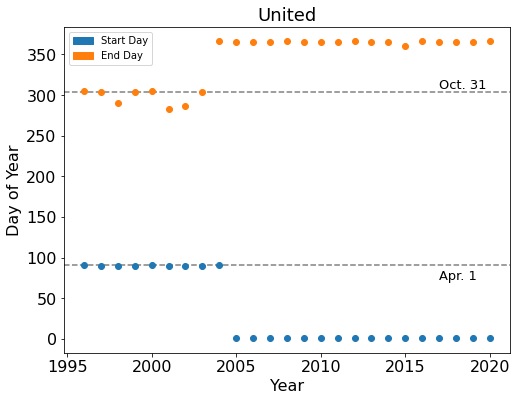

In [ ]:
united = timing[timing['DiversionName']=='UNITED WATER'].dropna()

plt.figure(figsize = (8,6))
plt.axhline(y=91, color='grey', linestyle = '--')
plt.text(2017, 73, 'Apr. 1', fontsize=13)
plt.axhline(y=304, color='grey', linestyle = '--')
plt.text(2017, 308, 'Oct. 31', fontsize=13)
plt.plot(united['Year'], united['StartDayofYear'], 'o')
plt.plot(united['Year'], united['EndDayofYear'], 'o')
start = mpatches.Patch(color='tab:blue', label='Start Day')
end = mpatches.Patch(color = 'tab:orange', label='End Day')
plt.xlabel('Year', size=16)
plt.ylabel('Day of Year', size=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(handles=[start,end])
plt.title('United', size=18)
plt.savefig('datasets/diversion_timeseries/figures/united_min_max.png')
plt.show()

In [ ]:
name = timing['DiversionName'].unique()
print(name)

['ATWELL' 'BALLENTYNE CANAL' 'BARBER PUMPS' 'BOISE CITY CANAL'
 'BOISE CITY PARKS' 'BOISE VALLEY CANAL (INCLUDED IN FARMERS UNION)'
 'BUBB CANAL' 'CALDWELL HIGHLINE CANAL' 'CAMPBELL CANAL'
 'CANYON COUNTY CANAL' 'CAPITOL VIEW PUMP (INCLUDED IN FARMERS UNION)'
 'CONWAY-HAMMING CANAL' 'Caldwell Lowline Canal' 'EAGLE ISLAND PARK'
 'ESTER SPIMPLOT PIPE' 'EUREKA #1 CANAL (INCLUDED IN PHYLLIS)' 'EUREKA #2'
 'FAIRVIEW ACRES' 'FARMERS UNION CANAL' 'HART-DAVIS CANAL' 'GOLDEN GATE'
 'GRAHAM-GILBERT CANAL' 'K ALBERTSON' 'LEMP CANAL' 'LITTLE PIONEER CANAL'
 'MACE-CATLIN CANAL' 'MACE-MACE CANAL' 'MCMANUS AND TEATER CANAL'
 'MEEVES CANAL' 'MIDDLETON CANAL'
 'NEW UNION CANAL (INCLUDED IN NEW DRY CREEK)' 'NEW DRY CREEK CANAL'
 'NEW YORK CANAL BL DIVERSION DAM' 'Notus Canal' 'PENITENTIARY CANAL'
 'PHYLLIS CANAL' 'Quinns Pond' 'RIVER RUN' 'RIDENBAUGH CANAL'
 'RIVERSIDE CANAL' 'RIVERSIDE VILLAGE' 'ROSSI MILL CANAL'
 'SHAKESPEARE FESTIVAL' 'SETTLERS CANAL' 'SEBREE CANAL'
 'SEVEN SUCKERS CANAL' 'SHIPLEY PU

In [ ]:
## --------------------------------------- ##
## EXPORT ANNUAL STATS (VOLUME AND TIMING) ##
## --------------------------------------- ##

merge_files = []

for i in range(len(canals)):
  time = season_df[i]
  div_name = time['DiversionName'][0]
  vol = tot[tot['DiversionName'] == div_name].reset_index().drop('index', axis=1)
  merge = vol.merge(time, on='Year', how='right').dropna().reset_index().drop(['index','DiversionName_y'], axis=1)
  out_path = os.path.join('datasets/diversion_timeseries/final_stats/'+div_name+'.csv')
  merge.to_csv(out_path)
  merge_files.append(merge)

In [ ]:
## --------------------------------------------- ##
## OUPUT A FULLY MERGED DATAFRAME FOR MODEL IN R ##
## --------------------------------------------- ##

full_data = pd.concat(merge_files).sort_values(by='DiversionName_x').reset_index().drop('index', axis=1)
out_path = 'datasets/diversion_timeseries/final_stats/model_inputs.csv' #EDIT for new ouput location
full_data.to_csv(out_path)


In [ ]:
## BASIC STATISTICS ON TIMING ##

time_stats = []

for i in range(len(canals)):
  canal_timing = season_df[i]
  avg_start = np.mean(canal_timing['StartDayofYear'][canal_timing['StartDayofYear'] != 'NaN'])
  std_start = np.std(canal_timing['StartDayofYear'][canal_timing['StartDayofYear'] != 'NaN'])
  avg_end = np.mean(canal_timing['EndDayofYear'][canal_timing['EndDayofYear'] != 'NaN'])
  std_end = np.std(canal_timing['EndDayofYear'][canal_timing['EndDayofYear'] != 'NaN'])
  avg_length = np.mean(canal_timing['Range'][canal_timing['Range'] != 'NaN'])
  std_length = np.std(canal_timing['Range'][canal_timing['Range'] != 'NaN'])
  time_stats.append([canal_timing['DiversionName'][1], avg_start, std_start, avg_end, std_end, avg_length, 
                     std_length])
  
time_stats = pd.DataFrame(time_stats, columns = ['DivName', 'avg_start', 'std_start', 
                                                 'avg_end','std_end', 'avg_length', 
                                                 'std_length'])

time_stats.to_csv('datasets/diversion_timeseries/figures/time_stats.csv')

In [ ]:
## Test if time series is stationary ##
## Mann_Kendall Test : A nonparametric test often used to detect changes in streamflow

# Test if volume time series is stationary
outs = []

for i in range(len(canals)):
  canal = canals[i]
  input = np.array(canal['CFS'])
  test = mk.seasonal_test(input, period=365, alpha=0.05)
  trend, hyp, pval, slope = [test.trend, test.h, test.p, test.slope]
  outs.append([canal['DiversionName'][0], trend, hyp, pval, slope])

mannkend_out = pd.DataFrame(outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope'])
# display(mannkend_out)

# Test to see if annual time series is stationary 

annual_outs = []

for i in range(len(canals)):
  canal = canals[i]
  annual = totals[:,i]
  test = mk.original_test(annual, alpha = 0.05)
  trend, hyp, pval, slope, intercept = [test.trend, test.h, test.p, test.slope, test.intercept]
  annual_outs.append([canal['DiversionName'][0], trend, hyp, pval, slope, intercept])
  
mannkend_annual = pd.DataFrame(annual_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope', 'Intercept'])
display(mannkend_annual)
mannkend_annual.to_csv('datasets/diversion_timeseries/figures/mannkend_annual.csv')

# Test if length of irrigation season time series is stationary

length_outs = []

for i in range(len(canals)):
  canal = season_df[i]
  input = np.array(canal['Range'][canal['Range'] != 'NaN'])
  test = mk.original_test(input, alpha=0.05)
  trend, hyp, pval, slope, intercept = [test.trend, test.h, test.p, test.slope, test.intercept]
  length_outs.append([canal['DiversionName'][0], trend, hyp, pval, slope, intercept])

mannkend_length = pd.DataFrame(length_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope', 'Intercept'])
# display(mannkend_length)

# Test if centroid time series is stationary

centroid_outs = []

for i in range(len(canals)):
  canal = centroid_df[i]
  input = np.array(canal['CentroidDay'])
  test = mk.original_test(input, alpha=0.05)
  trend, hyp, pval, slope = [test.trend, test.h, test.p, test.slope]
  centroid_outs.append([canal['DiversionName'][0], trend, hyp, pval, slope])

mannkend_centroid = pd.DataFrame(centroid_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope'])
# display(mannkend_centroid)




,Name,Trend,Hypothesis,Pvalue,Slope,Intercept
0,BALLENTYNE CANAL,no trend,False,1.634693e-01,-20.395963,4907.056282
1,BARBER PUMPS,decreasing,True,8.936597e-03,-4.170087,179.385194
2,BOISE CITY CANAL,decreasing,True,1.715019e-05,-85.555695,9191.197578
3,BOISE CITY PARKS,no trend,False,8.096686e-01,0.000000,76.165464
4,BOISE VALLEY CANAL (INCLUDED IN FARMERS UNION),no trend,False,6.602838e-02,-55.122313,15590.897330
5,BUREAU OF RECLAMATION INSTREAM FLOW RELEASE,increasing,True,1.981651e-04,957.873273,23323.412221
6,BUBB CANAL,decreasing,True,1.768054e-08,-60.860710,3023.974951
7,CALDWELL HIGHLINE CANAL,decreasing,True,2.423927e-02,-98.475892,14662.475534
8,CAMPBELL CANAL,decreasing,True,9.976408e-06,-94.932195,8635.984225
9,CANYON COUNTY CANAL,no trend,False,1.462806e-01,-44.718780,22107.300669


In [ ]:
## Add trend from Mann Kendall Test to volume stats and timing stats dataframes

base_stats['AnnualTrend'] = mannkend_annual['Trend']
time_stats['CentTrend'] = mannkend_centroid['Trend']
time_stats['LengthTrend'] = mannkend_length['Trend']

In [ ]:
## Calculate the annual percent change based on Mann Kendall slope and intercept

percent_change = []
for i in range(len(canals)):
  canal = canals[i]
  mann_row = mannkend_annual[mannkend_annual['Name'] == canal['DiversionName'][0]]
  if mann_row['Hypothesis'][i] == False:
    percent_change.append('Nan')
  elif str(mann_row['Trend'][i]) == 'increasing':
    end_val = mann_row['Intercept'][i]+mann_row['Slope'][i]*34
    change = (end_val-mann_row['Intercept'][i])/mann_row['Intercept'][i]
    percent_change.append(change)
  else:
    end_val = mann_row['Intercept'][i]+mann_row['Slope'][i]*34
    change = (mann_row['Intercept'][i]-end_val)/mann_row['Intercept'][i]
    percent_change.append(change)

base_stats['Intercept'] = mannkend_annual['Intercept']
base_stats['Slope(acre-ft)'] = mannkend_annual['Slope']
base_stats['PercentChange'] = percent_change

#Export an easy to read summary of each diversion
base_stats.to_csv('datasets/diversion_timeseries/figures/changethroughtime.csv')

In [ ]:
## Group canals based on the amount of discharge ##
## --------------------------------------------- ## 

mean50inc = []
mean50dec = []
mean10inc = []
mean10dec = []
mean0inc = []
mean0dec = []

for i in range(len(canals)):
  canal = base_stats.loc[i]
  if canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'increasing':
    mean50inc.append(canal)
  elif canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'decreasing':
    mean50dec.append(canal)
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'increasing':
    mean10inc.append(canal)
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'decreasing':
    mean10dec.append(canal)
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'increasing':
    mean0inc.append(canal)
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'decreasing':
    mean0dec.append(canal)
  else: 
    None


2
3
0
6
2
11


['BUBB CANAL']
['GRAHAM-GILBERT CANAL']
['LEMP CANAL']
['MACE-MACE CANAL']
['PENITENTIARY CANAL']
['SURPRISE_VALLEY_MICRON']
5
8
12


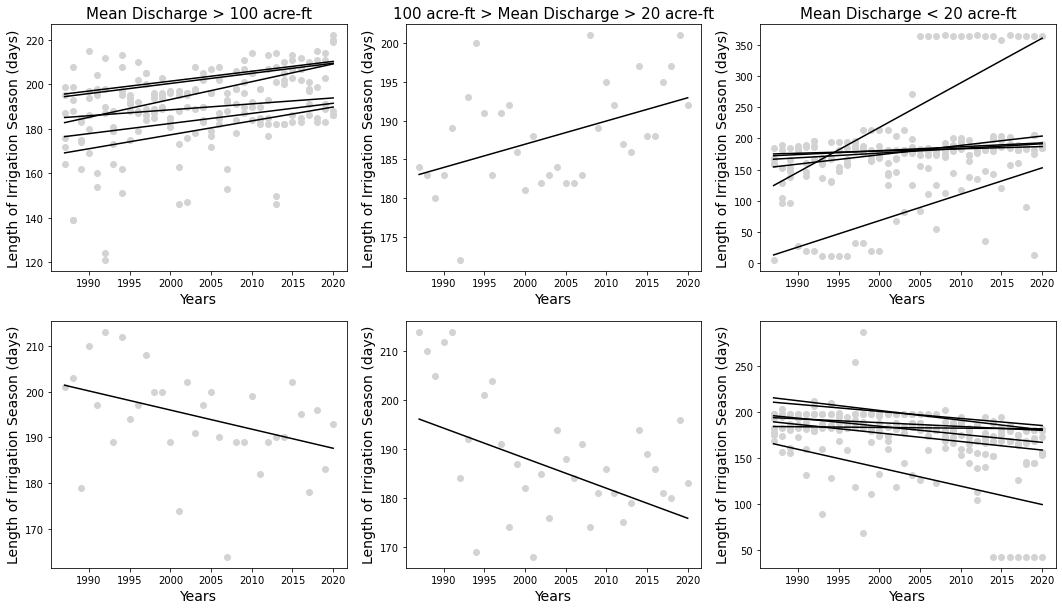

In [ ]:
## ---------------------------- ##
## CREATING FIGURES FOR RESULTS ## 
## ---------------------------- ##

figure, ax = plt.subplots(2, 3, figsize = (18,10))
year_slope = np.arange(0,34,1)
text = 'No increasing diversions'

for i in range(len(canals)):
  canal = mannkend_length.loc[i]
  vol = base_stats.loc[i]
  length = season_df[i]
  if vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'increasing':
    ax[0][0].plot(years, length['Range'], 'o', color='lightgrey')
    ax[0][0].set_xlabel('Years', size = 14)
    ax[0][0].set_ylabel('Length of Irrigation Season (days)', size=14)
    ax[0][0].set_title('Mean Discharge > 100 acre-ft', size=15)
  elif vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'decreasing':
    ax[1][0].plot(years, length['Range'], 'o', color='lightgrey')
    ax[1][0].set_xlabel('Years', size = 14)
    ax[1][0].set_ylabel('Length of Irrigation Season (days)', size=14)
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'increasing':
    ax[0][1].plot(years, length['Range'], 'o', color='lightgrey')
    ax[0][1].set_xlabel('Years', size = 14)
    ax[0][1].set_ylabel('Length of Irrigation Season (days)', size=14)
    ax[0][1].set_title('100 acre-ft > Mean Discharge > 20 acre-ft', size = 15)
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'decreasing':
    ax[1][1].plot(years, length['Range'], 'o', color='lightgrey')
    ax[1][1].set_xlabel('Years', size = 14)
    ax[1][1].set_ylabel('Length of Irrigation Season (days)', size=14)
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'increasing':
    ax[0][2].plot(years, length['Range'], 'o', color='lightgrey')
    ax[0][2].set_xlabel('Years', size = 14)
    ax[0][2].set_ylabel('Length of Irrigation Season (days)', size=14)
    ax[0][2].set_title('Mean Discharge < 20 acre-ft', size=15)
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'decreasing':
    ax[1][2].plot(years, length['Range'], 'o', color='lightgrey')
    ax[1][2].set_xlabel('Years', size = 14)
    ax[1][2].set_ylabel('Length of Irrigation Season (days)', size=14)
  else: 
    None

for i in range(len(canals)):
  canal = mannkend_length.loc[i]
  vol = base_stats.loc[i]
  if vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'increasing':
    ax[0][0].plot(years, (canal['Intercept']+canal['Slope']*year_slope), color='black')
  elif vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'decreasing':
    ax[1][0].plot(years, (canal['Intercept']+canal['Slope']*year_slope), color='black')
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'increasing':
    ax[0][1].plot(years, (canal['Intercept']+canal['Slope']*year_slope), color='black')
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'decreasing':
    ax[1][1].plot(years, (canal['Intercept']+canal['Slope']*year_slope), color='black')
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'increasing':
    print([canal['Name']])
    ax[0][2].plot(years, (canal['Intercept']+canal['Slope']*year_slope), color='black')
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'decreasing':
    ax[1][2].plot(years, (canal['Intercept']+canal['Slope']*year_slope), color='black')
  else: 
    None

plt.savefig('datasets/diversion_timeseries/figures/results_length.svg')

notrend50 = []
notrend10 = []
notrend0 = []
for i in range(len(canals)):
  canal = mannkend_length.loc[i]
  vol = base_stats.loc[i]
  if vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'no trend':
    notrend50.append(canal)
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'no trend':
    notrend10.append(canal)
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'no trend':
    notrend0.append(canal)
  else: 
    None

print(len(notrend50))
print(len(notrend10))
print(len(notrend0))


In [ ]:
mean50inc = []
mean50dec = []
mean10inc = []
mean10dec = []
mean0inc = []
mean0dec = []

for i in range(len(canals)):
  canal = base_stats.loc[i]
  length = mannkend_length.loc[i]
  if canal['Mean Discharge(cfs)'] > 50 and length['Trend'] == 'increasing':
    mean50inc.append(canal)
  elif canal['Mean Discharge(cfs)'] > 50 and length['Trend'] == 'decreasing':
    mean50dec.append(canal)
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and length['Trend'] == 'increasing':
    mean10inc.append(canal)
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and length['Trend'] == 'decreasing':
    mean10dec.append(canal)
  elif canal['Mean Discharge(cfs)'] < 10 and length['Trend'] == 'increasing':
    mean0inc.append(canal)
  elif canal['Mean Discharge(cfs)'] < 10 and length['Trend'] == 'decreasing':
    mean0dec.append(canal)
  else: 
    None

print(len(mean50inc))
print(len(mean50dec))
print(len(mean10inc))
print(len(mean10dec))
print(len(mean0inc))
print(len(mean0dec))

6
1
1
1
6
7


5
8
12


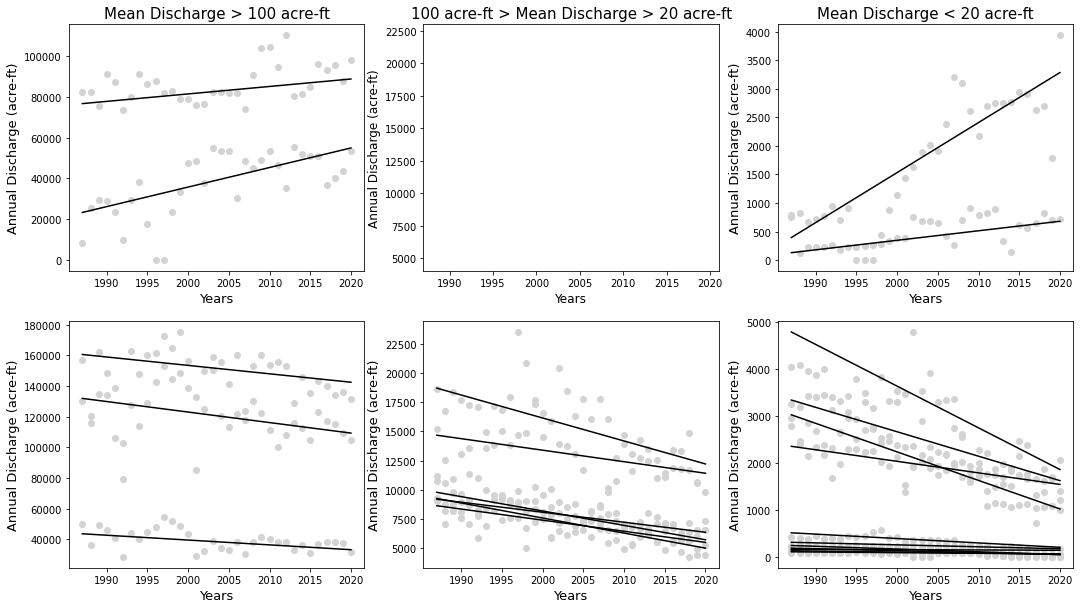

In [ ]:
## ---------------------------- ##
## CREATING FIGURES FOR RESULTS ## 
## ---------------------------- ##

## Change in Annual Volume Trends: 
figure, ax = plt.subplots(2, 3, figsize = (18,10))
year_slope = np.arange(0,34,1)
text = 'No increasing diversions'

for i in range(len(canals)):
  canal = base_stats.loc[i]
  ann_tots = totals[:,i]
  if canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'increasing':
    ax[0][0].plot(years, ann_tots, 'o', color='lightgrey')
    ax[0][0].set_xlabel('Years', size = 13)
    ax[0][0].set_ylabel('Annual Discharge (acre-ft)', size=13)
    ax[0][0].set_title('Mean Discharge > 100 acre-ft', size=15)
  elif canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'decreasing':
    ax[1][0].plot(years, ann_tots, 'o', color='lightgrey')
    ax[1][0].set_xlabel('Years', size = 13)
    ax[1][0].set_ylabel('Annual Discharge (acre-ft)', size=13)
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'increasing':
    ax[0][1].plot(years, ann_tots, 'o', color='lightgrey')
    ax[0][1].set_xlabel('Years', size = 13)
    ax[0][1].set_ylabel('Annual Discharge (acre-ft)', size=13)
    ax[0][1].set_title('100 acre-ft > Mean Discharge > 20 acre-ft')
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'decreasing':
    ax[1][1].plot(years, ann_tots, 'o', color='lightgrey')
    ax[1][1].set_xlabel('Years', size = 13)
    ax[1][1].set_ylabel('Annual Discharge (acre-ft)', size=13)
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'increasing':
    ax[0][2].plot(years, ann_tots, 'o', color='lightgrey')
    ax[0][2].set_xlabel('Years', size = 13)
    ax[0][2].set_ylabel('Annual Discharge (acre-ft)', size=13)
    ax[0][2].set_title('Mean Discharge < 20 acre-ft', size=15)
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'decreasing':
    ax[1][2].plot(years, ann_tots, 'o', color='lightgrey')
    ax[1][2].set_xlabel('Years', size = 13)
    ax[1][2].set_ylabel('Annual Discharge (acre-ft)', size=13)
  else: 
    ax[0][1].set_title('100 acre-ft > Mean Discharge > 20 acre-ft', size=15)
    ax[0][1].set_xlim([1987, 2021])
    ax[0][1].set_ylim([4000, 23000])
    ax[0][1].set_xlabel('Years', size=12)
    ax[0][1].set_ylabel('Annual Discharge (acre-ft)', size=12)
    # ax[0][1].text(1995, 17500, text)

for i in range(len(canals)):
  canal = base_stats.loc[i]
  if canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'increasing':
    ax[0][0].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope),color='black')
  elif canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'decreasing':
    ax[1][0].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope), color='black')
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'increasing':
    ax[0][1].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope))
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'decreasing':
    ax[1][1].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope), color='black')
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'increasing':
    ax[0][2].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope), color='black')
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'decreasing':
    ax[1][2].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope), color='black')
  else: 
    None
plt.savefig('datasets/diversion_timeseries/figures/results_discharge.svg')

notrend50 = []
notrend10 = []
notrend0 = []
for i in range(len(canals)):
  canal = mannkend_length.loc[i]
  vol = base_stats.loc[i]
  if vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'no trend':
    notrend50.append(canal)
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'no trend':
    notrend10.append(canal)
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'no trend':
    notrend0.append(canal)
  else: 
    None

print(len(notrend50))
print(len(notrend10))
print(len(notrend0))
